# igv variant classifier

In [116]:
from fastai.vision import *
from fastai import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [126]:
path = Path('/projects/da_workspace/szspace/data/giab/image2')

In [127]:
classes = ['positives','negatives']

In [100]:
# for c in classes:
#     print(c)
#     verify_images(path/c, delete=True, max_size=293) # max_size will change the image size on disk

## View data

In [5]:
doc(get_transforms)

somehow, the preprocessing gives 500x425 images
this is resovled by set dpi=1, and compensate lost pixels to generate 293x293 pixels images

# figure out my own stats 

imagenet_stats
normalize?

I think it is not appropriate to use imagenet_stats to normalize this hand-made images
I can just leave normalize() parameter empty so that it will grab a batch random pictures and decide the mean and std for normalizaion

In [130]:
# # no need to figure out mean and std myself, if i dont use pretrained model.
# train = Path('/projects/da_workspace/szspace/data/giab/image2/positives')
# images = (plt.imread(str(i)) for i in list(train.iterdir()) if plt.imread(str(i)).shape == (293, 293, 3))
# # # for some reason some image end up with different size

# # # print(images)
# images = np.stack(images)  # this takes time 
# means = np.mean(images, axis=(0, 1, 2))
# stds = np.std(images, axis=(0, 1, 2))

# means, stds

PosixPath('/projects/da_workspace/szspace/data/giab/image2/test/giab.1.1239339.png')

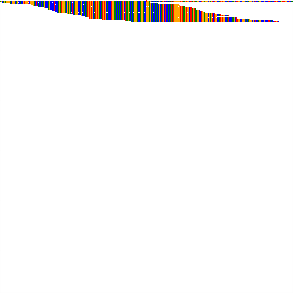

In [131]:
il = ImageImageList.from_folder(path)
il.items[0]
il[0]

In [139]:
path

PosixPath('/projects/da_workspace/szspace/data/giab/image2')

In [147]:
get_transforms?

In [172]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, 
                                  train=".", 
                                  valid_pct=0.2,        
                                  ds_tfms=get_transforms(do_flip=False,
                                                         flip_vert=False,
                                                         max_rotate=0, 
                                                         max_zoom=0, 
                                                         max_warp=0, 
                                                         max_lighting=0,
                                                         p_affine=0,
                                                         p_lighting=0 ), 
                                  size=293, 
                                  bs=32, 
                                  num_workers=4).normalize(imagenet_stats)

In [174]:

# normalized to this stats calculated by randomly grab a batch
data.stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [175]:
data

ImageDataBunch;

Train: LabelList (3051 items)
x: ImageList
Image (3, 293, 293),Image (3, 293, 293),Image (3, 293, 293),Image (3, 293, 293),Image (3, 293, 293)
y: CategoryList
negatives,negatives,negatives,negatives,negatives
Path: /projects/da_workspace/szspace/data/giab/image2;

Valid: LabelList (762 items)
x: ImageList
Image (3, 293, 293),Image (3, 293, 293),Image (3, 293, 293),Image (3, 293, 293),Image (3, 293, 293)
y: CategoryList
positives,positives,negatives,positives,negatives
Path: /projects/da_workspace/szspace/data/giab/image2;

Test: None

### add test data set

In [222]:
fd = '/projects/da_workspace/szspace/data/muts/positives'
# fd = '/projects/da_workspace/szspace/data/muts/no'
tl = ImageList.from_folder(fd)

data.add_test(tl)

In [224]:
data

ImageDataBunch;

Train: LabelList (3203 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
negatives,negatives,negatives,negatives,negatives
Path: /projects/da_workspace/szspace/data/giab/images;

Valid: LabelList (800 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
negatives,positives,positives,negatives,positives
Path: /projects/da_workspace/szspace/data/giab/images;

Test: LabelList (21 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: EmptyLabelList
,,,,
Path: /projects/da_workspace/szspace/data/giab/images

Good! Let's take a look at some of our pictures then.

In [144]:
data.classes

['negatives', 'positives']

In [145]:
data.c

2

In [255]:
data.show_batch?

### due to cropping, lost many information surrounding the mutation, don't have much control over the screen shots. better reconstruct the image myself by pulling out alignment information using samtools.

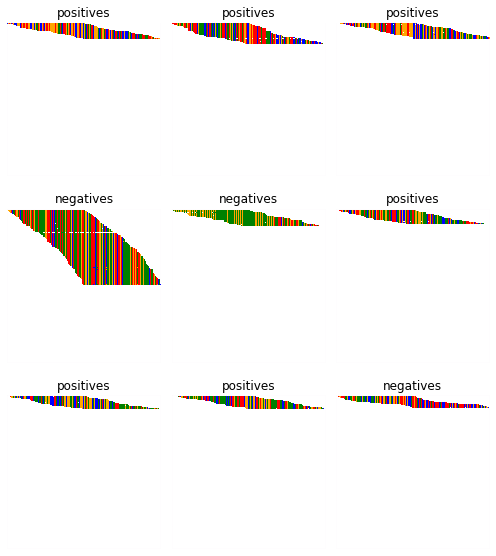

In [176]:
data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(7,8))
# plt.savefig('test.png')

In [151]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['negatives', 'positives'], 2, 3051, 762)

(293, 293, 3)

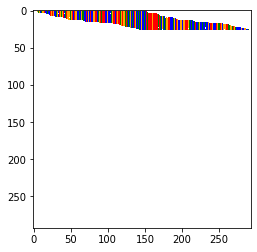

In [188]:
plt.imshow(image2np(data.train_ds[0][0].data))
image2np(data.train_ds[0][0].data).shape

(293, 293, 3)

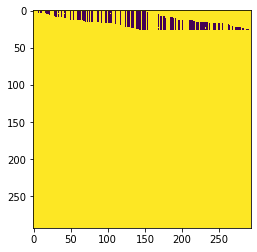

In [187]:
# one channel, (293, 293)
plt.imshow(image2np(data.train_ds[0][0].data)[:, :, 0])

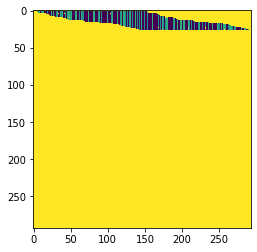

In [189]:
plt.imshow(image2np(data.train_ds[0][0].data)[:, :, 1])

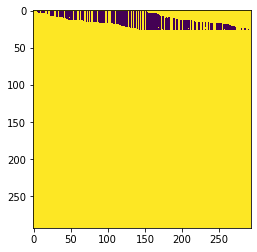

In [190]:
plt.imshow(image2np(data.train_ds[0][0].data)[:, :, 2])

## Train model

In [157]:
cnn_learner?

In [193]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, pretrained=False)

In [194]:
learn.fit_one_cycle(4, max_lr=0.003)

epoch,train_loss,valid_loss,accuracy,time
0,0.869506,0.940599,0.496063,00:18
1,0.784169,0.692494,0.517060,00:17
2,0.748002,0.702079,0.520997,00:17
3,0.713320,0.698449,0.492126,00:17


In [11]:
learn.save('stage-1')

In [12]:
learn.unfreeze()

In [6]:
!nvidia-smi

Thu Aug 22 14:08:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 361.93.02              Driver Version: 361.93.02                 |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  On   | 0000:05:00.0     Off |                  N/A |
| 23%   63C    P8    28W / 250W |      3MiB / 12209MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  On   | 0000:06:00.0     Off |                  N/A |
| 22%   58C    P8    15W / 250W |      3MiB / 12212MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [ ]:
# !kill 18136


In [160]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


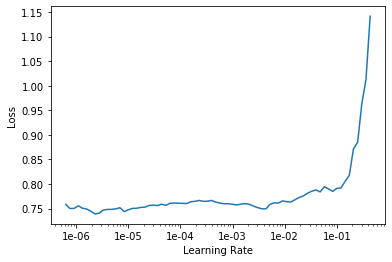

In [161]:
learn.recorder.plot()

In [ ]:
# If the plot is not showing try to give a start and end learning rate# learn.lr_find(start_lr=1e-5, end_lr=1e-1)learn.recorder.plot()

In [18]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,5e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.494960,0.466602,0.779817,01:18
1,0.504553,0.465188,0.779817,01:18


In [12]:
learn.save('stage-2')

## Interpretation

In [27]:
learn.load('stage-2');

In [28]:
data.test_ds

In [100]:
doc(learn.pred_batch)

In [147]:
learn.pred_batch?

In [29]:
data.classes

['negatives', 'positives']

In [230]:
data.train_ds
data.test_ds

LabelList (3203 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
negatives,negatives,negatives,negatives,negatives
Path: /projects/da_workspace/szspace/data/giab/images

LabelList (21 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: EmptyLabelList
,,,,
Path: /projects/da_workspace/szspace/data/giab/images

In [152]:
doc(learn.pred_batch)

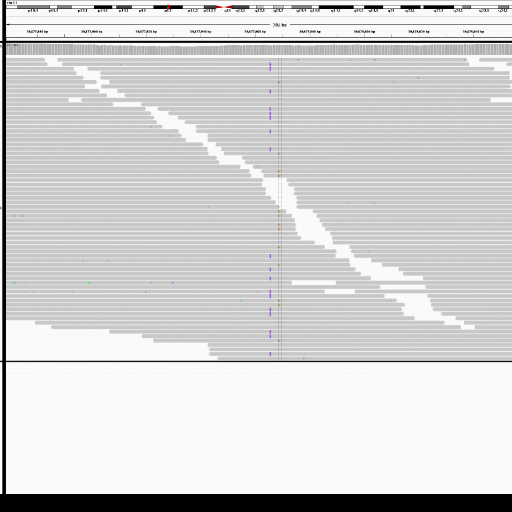

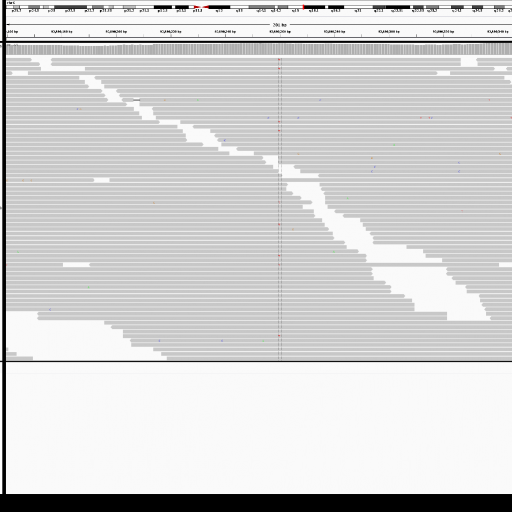

In [192]:
learn.data.test_ds[18][0]; learn.data.test_ds[19][0]

In [13]:
fd = '/projects/da_workspace/szspace/data/muts/positives'
fd = '/projects/da_workspace/szspace/data/muts/negatives'
tl = ImageList.from_folder(fd)

data.add_test(tl)

In [234]:
# specify which data set you want to predict
preds = learn.pred_batch(ds_type=DatasetType.Test) 
# learn.pred_batch(ds_type=DatasetType.Valid)
# learn.pred_batch() # default is valid data set

In [235]:
preds.shape
idx = torch.tensor([0])
# number of wrong predicitons for the positive images
(torch.index_select(preds, 1, idx) > torch.index_select(preds, 1, torch.tensor([1]))).sum()

torch.Size([32, 2])

tensor(20)

In [236]:
learn.predict?

In [15]:
data

ImageDataBunch;

Train: LabelList (3052 items)
x: ImageList
Image (3, 425, 425),Image (3, 425, 425),Image (3, 425, 425),Image (3, 425, 425),Image (3, 425, 425)
y: CategoryList
proc,negatives,negatives,negatives,negatives
Path: /projects/da_workspace/szspace/data/giab/images;

Valid: LabelList (762 items)
x: ImageList
Image (3, 425, 425),Image (3, 425, 425),Image (3, 425, 425),Image (3, 425, 425),Image (3, 425, 425)
y: CategoryList
negatives,positives,positives,positives,negatives
Path: /projects/da_workspace/szspace/data/giab/images;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: /projects/da_workspace/szspace/data/giab/images

In [14]:
for i in range(21):
    item = learn.data.test_ds[i][0]
    batch = learn.data.one_item(item)
    pred = learn.pred_batch(batch=batch)
    print(pred)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [90]:
path

PosixPath('/projects/da_workspace/szspace/data/giab/images')

In [57]:
learn.export('/projects/da_workspace/szspace/data/giab/images/models/stage-2.pkl')

In [30]:
interp = ClassificationInterpretation.from_learner(learn)

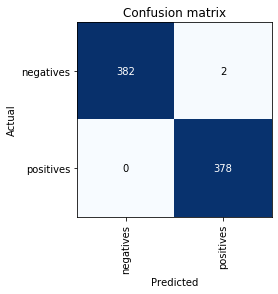

In [31]:
interp.plot_confusion_matrix()
of = '/home/szong/giab_validation_confusion_matrix.png'
plt.savefig(of, bbox_inches='tight', dpi=150)

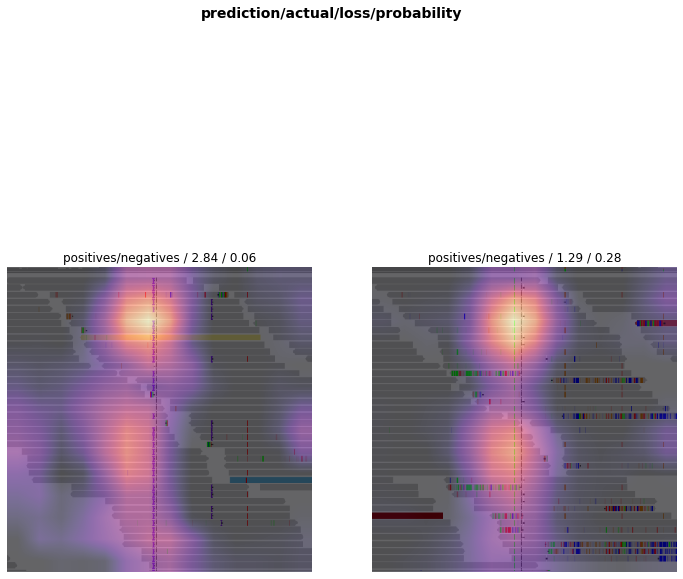

In [33]:
interp.plot_top_losses(2, heatmap=True) # heatmap show which part of the image contribute to the prediction

# predict

In [127]:
ipath = Path('/projects/da_workspace/szspace/data/muts/yes')
# img = open_image(ipath/'A78434_11_48894652_48894852.png')
# img = open_image(ipath/'A78437_19_41608695_41608895.png')

In [121]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class, pred_class.data

(Category negatives, tensor(0))

In [28]:
pred_class.data

tensor(1)

In [252]:
f = '/projects/da_workspace/szspace/data/muts/negatives/negs_imgs.txt'
ipath = Path('/projects/da_workspace/szspace/data/muts/negatives/')
imgs = pd.read_csv(f, header=None)[0].tolist()
pc = 0
nc = 0
for img in imgs:
    img = open_image(ipath/img)
    pred_class, pred_idx, outputs = learn.predict(img)
#     print(pred_class.data)
    if pred_class.data == 1: pc += 1
    elif pred_class.data == 0: nc += 1
    else: print('Error!')


OSError: cannot identify image file '/projects/da_workspace/szspace/data/muts/negatives/negs_imgs.txt'

In [253]:
pc

194

In [254]:
nc

997

can i create a databunch here?

In [49]:
path = Path('/projects/da_workspace/szspace/data/muts/no')
# data = ImageDataBunch.from_folder(path, 
#                                   train=".", 
#                                   valid_pct=0.2,        
#                                   ds_tfms=get_transforms(do_flip=False,max_rotate=None, max_zoom=1., max_warp=None, 
#                                                          max_lighting=None,p_affine=0,p_lighting=0 ), 
#                                   size=512, bs=32, 
#                                   num_workers=4).normalize(imagenet_stats)

In [65]:
path = Path('/projects/da_workspace/szspace/data/muts')
data = ImageDataBunch.from_folder(path, test='.')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [62]:
load_learner?

In [61]:
load_learner('/projects/da_workspace/szspace/data/giab/images/models', 'stage-2.pkl', test)

NameError: name 'test' is not defined

# train with 256x256 size image

In [52]:
learn.data

ImageDataBunch;

Train: LabelList (3203 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
negatives,negatives,negatives,negatives,negatives
Path: /projects/da_workspace/szspace/data/giab/images;

Valid: LabelList (800 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
negatives,positives,positives,negatives,positives
Path: /projects/da_workspace/szspace/data/giab/images;

Test: None

In [53]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.026151,0.073532,0.017500,00:16
1,0.019644,0.065938,0.013750,00:16


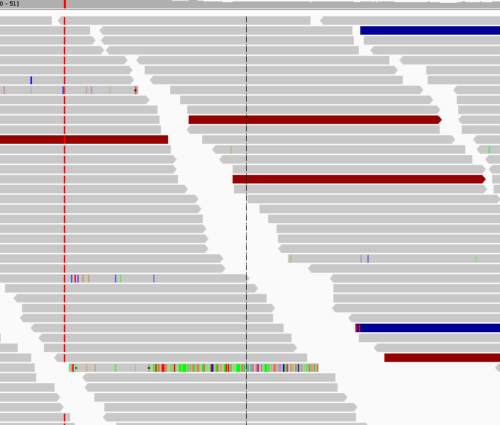

In [35]:
import PIL
f = '/projects/da_workspace/szspace/data/giab/images/negatives/chr9_86,282,732_86,283,032.png'
PIL.Image.open(f)

## Putting your model in production

First thing first, let's export the content of our `Learner` object for production:

In [12]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [13]:
defaults.device = torch.device('cpu')

In [237]:
# img = open_image(path/'black'/'00000021.jpg')
# img

In [15]:
learn = load_learner(path)

pred_class,pred_idx,outputs = learn.predict(img)
pred_class